In [7]:
import os
import openai
import pandas as pd
import scipy
from dotenv import load_dotenv
from langchain.embeddings import OpenAIEmbeddings
from openai.embeddings_utils import cosine_similarity

# Load environment variables (contains OPENAI_API_BASE and OPENAI_API_KEY)
load_dotenv(override=True)

# Configure Azure OpenAI Service API
openai.api_type = "azure"
openai.api_version = "2022-12-01"
openai.api_base = os.getenv('OPENAI_API_BASE') # looks like https://********.openai.azure.com/
openai.api_key = os.getenv("OPENAI_API_KEY")

# Initialize embedding model
embeddings = OpenAIEmbeddings(model = 'text-embedding-ada-002', deployment = 'text-embedding-ada-002',  chunk_size=1)
print('test')

test


In [8]:
text = "This is just a test"

# Embed a single document
e = embeddings.embed_query(text)

print(e)
print(len(e))

[-0.010031012400679239, 0.002363352705139523, 0.009305801786561171, -0.0045502160644454335, -0.020395751193564623, 0.013875271547451488, -0.03111346681547216, -0.01193709714941775, -0.006584657082058519, -0.03855810898977913, 0.01369557286415934, 0.003988659308971903, -0.0036902316706888885, 0.0028944251785389965, 0.004373726718611821, 0.0013196590040055094, 0.021371255670514764, -0.004973790401313851, -0.0070274846497105515, -0.008432982138446184, 0.005487214079828343, 0.001197720827971425, -0.01513315953652893, 0.031909274471775224, -0.032422697684628445, -0.015030474707693779, 0.015197336972474317, -0.028726047571853118, 0.012245151635923206, -0.006369660808996407, 0.014991967314804013, -0.00795806538716019, 0.015312857288498545, -0.034348035664150574, -0.004717078794887239, -0.018406233915452038, -0.009902656597465932, -0.022385266609032135, 0.01358005254813511, -0.017713112019306664, -0.0020167919898974704, 0.024118070418073033, -0.00788746927629773, -0.028212624358999894, 0.00401

In [35]:
def get_similarity_from_text(text1, text2):
    e1 = embeddings.embed_query(text1)
    e2 = embeddings.embed_query(text2)
    s = cosine_similarity(e1, e2)
    print(f"Somiglianza tra '{text1}' e '{text2}': {s}")

get_similarity_from_text("ragazzo", "ragazza")
get_similarity_from_text("ragazzo", "bambino")
get_similarity_from_text("ragazzo", "donna")

get_similarity_from_text("Italia", "Roma")
get_similarity_from_text("Switzerland ", "Zurich")
get_similarity_from_text("California", "Los Angeles")


Somiglianza tra 'ragazzo' e 'ragazza': 0.9371455305554139
Somiglianza tra 'ragazzo' e 'bambino': 0.8620923331020662
Somiglianza tra 'ragazzo' e 'donna': 0.8434832832512844
Somiglianza tra 'Italia' e 'Roma': 0.891014763666595
Somiglianza tra 'Switzerland ' e 'Zurich': 0.911240100712202
Somiglianza tra 'California' e 'Los Angeles': 0.8623730743290187


In [36]:
story1 = "Once upon a time, there was a little girl named Sarah. She lived with her family in a small village near the woods. Every morning Sarah would wake up early, get dressed, and go outside to play."
story2 = "One day, while Sarah was playing in the woods, she noticed a small rabbit hopping around in the grass. She decided to follow it, hoping to see where it would go. The rabbit kept hopping until it reached the entrance of a small cave."
insurance_clause = "In the event of any losses or damages incurred by either party due to unforeseen circumstances, both parties agree to be liable for their respective liabilities and hold the other harmless for any and all damages and losses sustained."

get_similarity_from_text(story1, story2)
get_similarity_from_text(story1, insurance_clause)

Somiglianza tra 'Once upon a time, there was a little girl named Sarah. She lived with her family in a small village near the woods. Every morning Sarah would wake up early, get dressed, and go outside to play.' e 'One day, while Sarah was playing in the woods, she noticed a small rabbit hopping around in the grass. She decided to follow it, hoping to see where it would go. The rabbit kept hopping until it reached the entrance of a small cave.': 0.9084378968909292
Somiglianza tra 'Once upon a time, there was a little girl named Sarah. She lived with her family in a small village near the woods. Every morning Sarah would wake up early, get dressed, and go outside to play.' e 'In the event of any losses or damages incurred by either party due to unforeseen circumstances, both parties agree to be liable for their respective liabilities and hold the other harmless for any and all damages and losses sustained.': 0.7223016948630127


In [37]:
import pandas as pd

df = pd.read_csv('data/libraries_dataset.csv', header=0, sep=';')

print('none')

# only keep library_name and description column
df = df[['library_name', 'description']]

# add embedding column with embedding
df['embedding'] = df['description'].apply(lambda x: embeddings.embed_query(x))

df.head()

none


,library_name,description,embedding
0,TensorFlow,The first in the list of python libraries for ...,"[-0.012400477817136478, -0.0028902598871368155..."
1,SciPy,SciPy (Scientific Python) is another free and ...,"[0.007484675537389299, -0.002401724040960429, ..."
2,Numpy,NumPy (Numerical Python) is the fundamental pa...,"[-0.007755336265147036, -0.0035941830730589343..."
3,Pandas,Pandas (Python data analysis) is a must in the...,"[-0.009512467930032544, 0.0067418462254435155,..."
4,Matplotlib,Matplotlib has powerful yet beautiful visualiz...,"[0.000595139941588776, 0.0008655833688078039, ..."


In [43]:
# Let's pick a movie that exists in df, keeping in mind we only have 500 movies in it!
request = "I need a python library to parse html code retrived with an HTTP request"
# "I need a python library to make graphs and visualizations" 
# "I need a python library to parse html code retrived with an HTTP request"

# get embedding for movie
# e = df[df['library_name'] == request]['embedding'].values[0]

# get embedding for request
request_embedding = embeddings.embed_query(request)

# get cosine similarity between movie and all other movies and sort ascending
similarities = df['embedding'].apply(lambda x: cosine_similarity(x, request_embedding))

# combine library_name from df and similiaries and sort ascending by similarity
recommendations = pd.concat([df['library_name'], similarities], axis=1).sort_values(by='embedding', ascending=False)
recommendations.head(10)

,library_name,embedding
9,BeautifulSoup,0.819023
8,Scrapy,0.817715
6,Scikit-learn,0.761493
3,Pandas,0.758129
7,PyTorch,0.755811
0,TensorFlow,0.755700
1,SciPy,0.746985
4,Matplotlib,0.724728
5,Keras,0.711553
2,Numpy,0.703839


In [40]:
import pandas as pd

# generate an array with different city names
cities = ['Jakarta', 'Hong Kong', 'Tokyo', 'Bangkok', 'Shanghai', 'Ho Chi Minh City', 'Beijing',
          'New York', 'Los Angeles', 'San Francisco', 'Chicago',
          'Paris', 'Rome', 'Barcelona', 'Madrid', 'Amsterdam', 'Berlin']

cities_df = pd.DataFrame({"city": cities})

# generate embeddings for all cities
cities_df['cities_embeddings'] = [embeddings.embed_query(city) for city in cities]


In [41]:
# use PCA to reduce dimensionality to 3
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
t = pca.fit_transform(cities_df['cities_embeddings'].tolist())


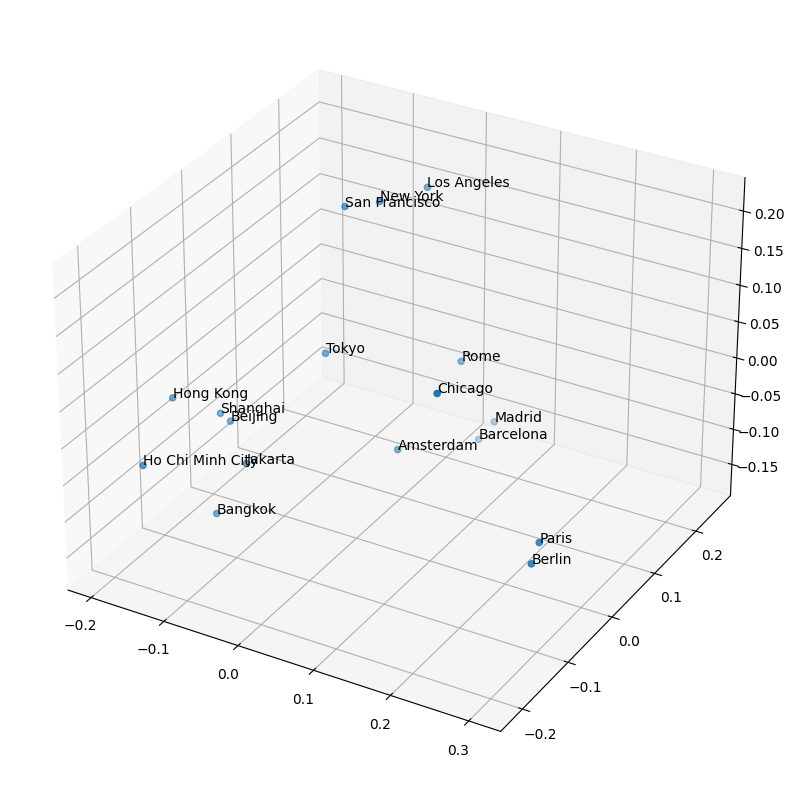

In [42]:
# draw t in a scatter plot and put names on each point
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(t[:,0], t[:,1], t[:,2])
for i, txt in enumerate(cities):
    ax.text(t[i,0], t[i,1], t[i,2], txt)
plt.show()
